In [122]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

print(cv2.__version__)

4.9.0


In [4]:
train = np.loadtxt("train.csv", delimiter=',', skiprows=1)
test = np.loadtxt("test.csv", delimiter=',', skiprows=1)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))


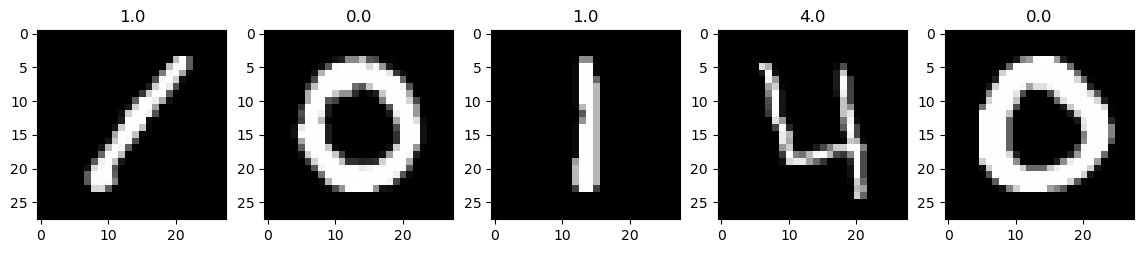

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Prediction based on the Gradient Histogram (HOG)

### Calculate the X and Y components of the gradient using the Sobel operator

In [9]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [10]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

### Calculate the angle and length of the gradient vector

In [11]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [12]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

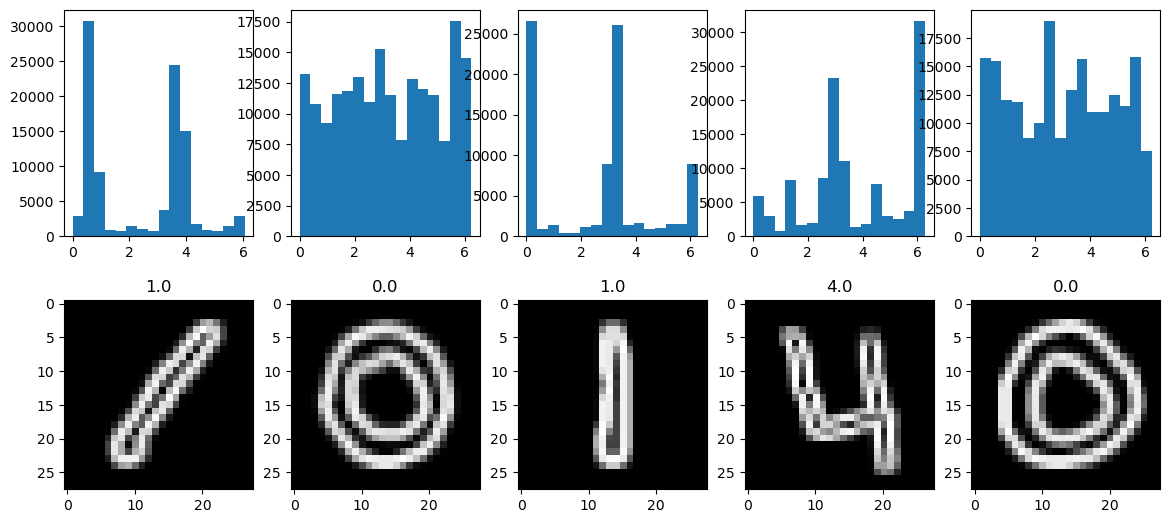

In [13]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

### Calculating gradient histograms

In [14]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [15]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

### Normalize the histogram vector

In [16]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

### Splitting the sample into training and validation

In [17]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

### Training xgboost

In [61]:
! pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 326.8 kB/s eta 0:05:06
   ---------------------------------------- 0.1/99.8 MB 581.0 kB/s eta 0:02:52
   ---------------------------------------- 0.2/99.8 MB 1.3 MB/s eta 0:01:20
   ---------------------------------------- 0.5/99.8 MB 2.2 MB/s eta 0:00:45
   ---------------------------------------- 0.8/99.8 MB 2.8 MB/s eta 0:00:35
    --------------------------------------- 1.8/99.8 MB 5.4 MB/s eta 0:00:19
   - -------------------------------------- 3.1/99.8 MB 8.1 MB/s eta 0:00:12
   - -------------------------------------

In [80]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=10)


In [83]:
#Parameter Tuning
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search = GridSearchCV(xgb, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)

In [84]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.16],
                         'max_depth': [10, 30, 50],
                         'min_child_weight': [1, 3, 6], 'n_estimators': [200]},
             verbose=10)

In [85]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [86]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 30,
 'min_child_weight': 6,
 'n_estimators': 200}

In [87]:
xgb = XGBClassifier(max_depth=30, learning_rate=0.1, min_child_weight=6, n_estimators=200, random_state=10)

In [88]:
xgb.fit(x_train, y_train)
pred = xgb.predict(x_val)
xgb.score(x_train, y_train)

1.0

In [89]:
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.45      0.43      0.44       816
         1.0       0.98      0.97      0.97       909
         2.0       0.53      0.47      0.50       846
         3.0       0.67      0.69      0.68       937
         4.0       0.76      0.73      0.75       839
         5.0       0.62      0.68      0.65       702
         6.0       0.50      0.51      0.51       785
         7.0       0.87      0.82      0.84       893
         8.0       0.53      0.58      0.55       835
         9.0       0.70      0.71      0.71       838

    accuracy                           0.67      8400
   macro avg       0.66      0.66      0.66      8400
weighted avg       0.67      0.67      0.67      8400



Overfiting model

### Let's try to train catboost

In [68]:
! pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e8/37/3afd3c02798734efcd7840bfa872d3efc06f5d5c92f9613fea3ff5b4311f/catboost-1.2.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/de/5e/fcbb22c68208d39edff467809d06c9d81d7d27426460ebc598e55130c1aa/graphviz-0.20.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.1 MB 656.4 kB/s eta 0:02:34
   ---------------------------------------- 0.2/101.1 MB 1.5 MB/s eta 0:01:09
   ---------------------------------------- 0.5/101.1 MB 2.7 MB/s eta 0:00:38
   ---------------------------------------- 0.7/101.1 MB 3.4 MB/s eta 0:00:30
    --------------------------------------- 1.3/101.1 MB 4.9 MB/s eta 0:00:21
   - -------------------------------------- 2.5/101.1 

In [69]:
from catboost import CatBoostClassifier

In [94]:
cat = CatBoostClassifier(random_state=42)



In [95]:
cat.fit(x_train, y_train)
pred = cat.predict(x_val)
cat.score(x_train, y_train)

Learning rate set to 0.09466
0:	learn: 2.1410330	total: 75.9ms	remaining: 1m 15s
1:	learn: 2.0303492	total: 136ms	remaining: 1m 8s
2:	learn: 1.9503815	total: 197ms	remaining: 1m 5s
3:	learn: 1.8763680	total: 267ms	remaining: 1m 6s
4:	learn: 1.8137437	total: 328ms	remaining: 1m 5s
5:	learn: 1.7591654	total: 388ms	remaining: 1m 4s
6:	learn: 1.7092279	total: 453ms	remaining: 1m 4s
7:	learn: 1.6678701	total: 508ms	remaining: 1m 2s
8:	learn: 1.6269978	total: 565ms	remaining: 1m 2s
9:	learn: 1.5900398	total: 616ms	remaining: 1m
10:	learn: 1.5567650	total: 671ms	remaining: 1m
11:	learn: 1.5279619	total: 725ms	remaining: 59.7s
12:	learn: 1.5015838	total: 780ms	remaining: 59.3s
13:	learn: 1.4753475	total: 831ms	remaining: 58.5s
14:	learn: 1.4507780	total: 883ms	remaining: 58s
15:	learn: 1.4293510	total: 949ms	remaining: 58.3s
16:	learn: 1.4110503	total: 1.01s	remaining: 58.5s
17:	learn: 1.3919356	total: 1.08s	remaining: 58.7s
18:	learn: 1.3746378	total: 1.19s	remaining: 1m 1s
19:	learn: 1.35608

0.8257738095238095

In [96]:
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.45      0.44      0.44       816
         1.0       0.97      0.96      0.96       909
         2.0       0.55      0.51      0.53       846
         3.0       0.68      0.70      0.69       937
         4.0       0.74      0.73      0.73       839
         5.0       0.65      0.70      0.67       702
         6.0       0.52      0.51      0.52       785
         7.0       0.87      0.83      0.85       893
         8.0       0.53      0.58      0.56       835
         9.0       0.71      0.70      0.70       838

    accuracy                           0.67      8400
   macro avg       0.67      0.67      0.67      8400
weighted avg       0.67      0.67      0.67      8400



###  Train lightgbm

In [73]:
! pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 653.6 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.3 MB 1.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.3 MB 3.0 MB/s eta 0:00:01
   ---------------------- ----------------- 0.7/1.3 MB 3.6 MB/s eta 0:00:01
   -------------------------------------- - 1.3/1.3 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.0 MB/s eta 0:00:00


In [74]:
from lightgbm import LGBMClassifier

In [97]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 16
[LightGBM] [Info] Start training from score -2.315767
[LightGBM] [Info] Start training from score -2.186126
[LightGBM] [Info] Start training from score -2.311254
[LightGBM] [Info] Start training from score -2.286641
[LightGBM] [Info] Start training from score -2.341116
[LightGBM] [Info] Start training from score -2.385385
[LightGBM] [Info] Start training from score -2.304969
[LightGBM] [Info] Start training from score -2.259480
[LightGBM] [Info] Start training from score -2.342663
[LightGBM] [Info] Start training from score -2.305566


LGBMClassifier(random_state=42)

In [98]:
pred = lgbm.predict(x_val)
lgbm.score(x_train, y_train)

0.8424702380952381

In [99]:
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.44      0.42      0.43       816
         1.0       0.98      0.97      0.97       909
         2.0       0.52      0.48      0.50       846
         3.0       0.67      0.69      0.68       937
         4.0       0.75      0.73      0.74       839
         5.0       0.64      0.68      0.66       702
         6.0       0.51      0.50      0.50       785
         7.0       0.86      0.80      0.83       893
         8.0       0.52      0.58      0.55       835
         9.0       0.68      0.70      0.69       838

    accuracy                           0.66      8400
   macro avg       0.66      0.66      0.66      8400
weighted avg       0.66      0.66      0.66      8400



### Conclusion

All four models show the same result when using the gradient histogram (HOG) = 0.67
Let's look at the predictions based on the results of the CatBoost model

In [105]:
pred_test = xgb.predict(test_hist)

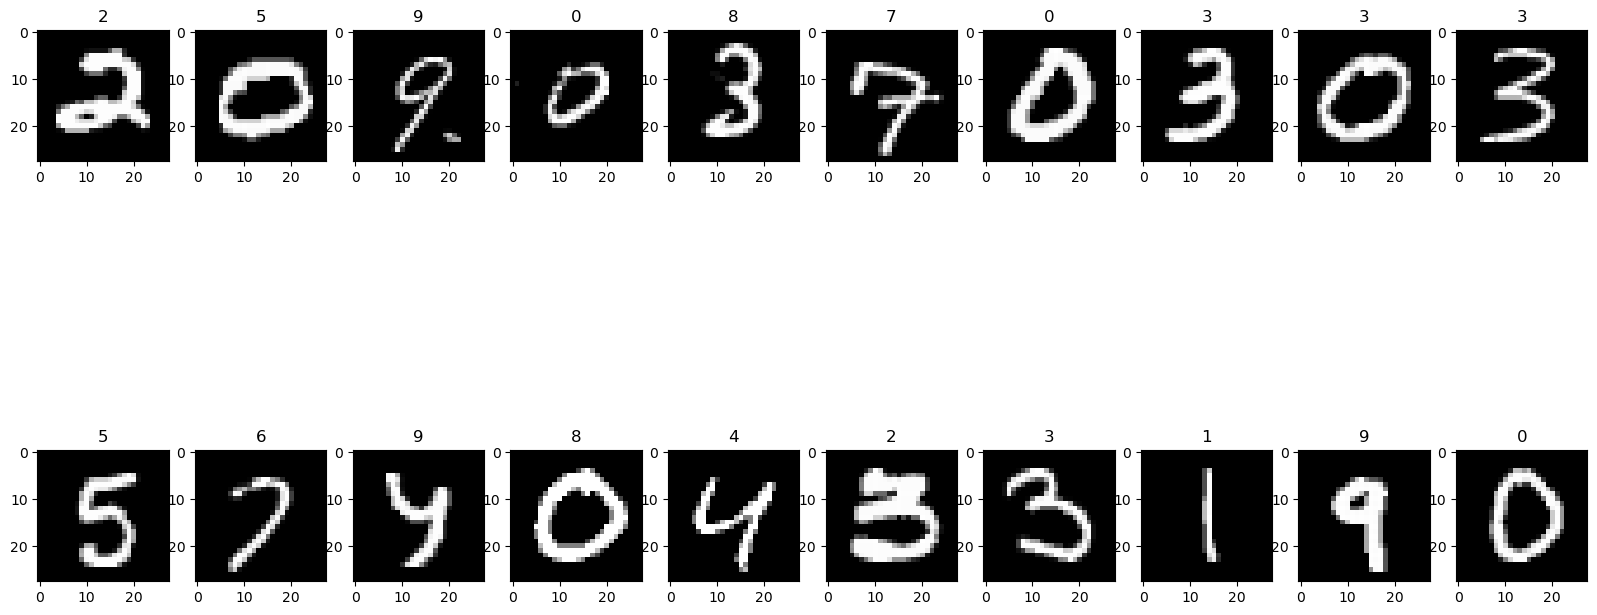

In [106]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Prediction based on the PCA dimension reduction method

In [108]:
X_train, X_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.3, random_state=42 )

In [126]:
X_train = X_train.reshape(-1, 28 * 28).astype(np.float32)
X_val = X_val.reshape(-1, 28 * 28).astype(np.float32)

In [112]:
# centering the data
X_mean = X_train.mean(axis=0)
X_train -= X_mean

In [113]:
# feature covariance matrix
cov = np.dot(X_train.T, X_train) / X_train.shape[0]

In [114]:
U, S, _ = np.linalg.svd(cov)
# U - eigenvectors of the covariance matrix
# S - eigenvalues

Text(0.5, 1.0, 'График совокупной дисперсии')

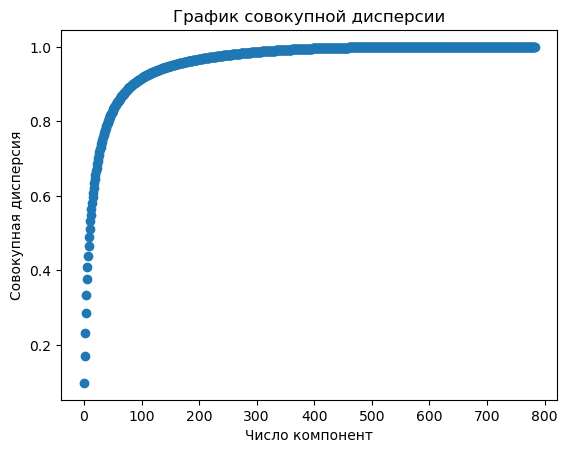

In [116]:
# cosum of eigenvalues
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')
plt.xlabel('Число компонент')
plt.ylabel('Совокупная дисперсия')
plt.title('График совокупной дисперсии')

Lowering the dimension

In [120]:
S_thr = 0.85  # setting the threshold for the accumulated sum of eigenvalues

# we determine the required number of components for a given threshold
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=58 S=0.851


Let's train catboost using the dimensionality reduction method for the resulting number of components

In [123]:
model = make_pipeline(PCA(n_components=39,
                              copy = True,
                              whiten = False,
                              svd_solver = 'auto',
                              tol = 0.0, 
                              iterated_power = 'auto',
                              random_state = 21),
                          StandardScaler(), 
                          cat)

In [124]:
model.fit(X_train, y_train)

Learning rate set to 0.094018
0:	learn: 2.0029976	total: 112ms	remaining: 1m 52s
1:	learn: 1.8088460	total: 220ms	remaining: 1m 49s
2:	learn: 1.6687704	total: 343ms	remaining: 1m 54s
3:	learn: 1.5591627	total: 455ms	remaining: 1m 53s
4:	learn: 1.4622923	total: 579ms	remaining: 1m 55s
5:	learn: 1.3837479	total: 687ms	remaining: 1m 53s
6:	learn: 1.3181407	total: 801ms	remaining: 1m 53s
7:	learn: 1.2624705	total: 911ms	remaining: 1m 52s
8:	learn: 1.2063820	total: 1.03s	remaining: 1m 53s
9:	learn: 1.1629196	total: 1.13s	remaining: 1m 51s
10:	learn: 1.1185943	total: 1.24s	remaining: 1m 51s
11:	learn: 1.0807853	total: 1.34s	remaining: 1m 50s
12:	learn: 1.0454988	total: 1.45s	remaining: 1m 50s
13:	learn: 1.0055208	total: 1.56s	remaining: 1m 50s
14:	learn: 0.9770210	total: 1.67s	remaining: 1m 49s
15:	learn: 0.9425280	total: 1.78s	remaining: 1m 49s
16:	learn: 0.9164632	total: 1.9s	remaining: 1m 49s
17:	learn: 0.8916934	total: 2s	remaining: 1m 49s
18:	learn: 0.8701540	total: 2.1s	remaining: 1m 4

Pipeline(steps=[('pca', PCA(n_components=39, random_state=21)),
                ('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000028776C43650>)])

In [129]:
pred = model.predict(X_val)
model.score(X_train, y_train)

0.9910544217687075

It looks like catboost has retrained on this data. The result is acceptable for research, but for practical tasks it is better to choose another model

In [130]:
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85      1200
         1.0       0.99      0.51      0.68      1389
         2.0       0.93      0.82      0.87      1294
         3.0       0.85      0.91      0.88      1355
         4.0       0.96      0.74      0.84      1222
         5.0       0.92      0.65      0.76      1085
         6.0       0.99      0.76      0.86      1256
         7.0       0.97      0.80      0.88      1359
         8.0       0.40      0.98      0.57      1209
         9.0       0.80      0.84      0.82      1231

    accuracy                           0.79     12600
   macro avg       0.87      0.79      0.80     12600
weighted avg       0.87      0.79      0.80     12600



In [132]:
pred_test = model.predict(test)

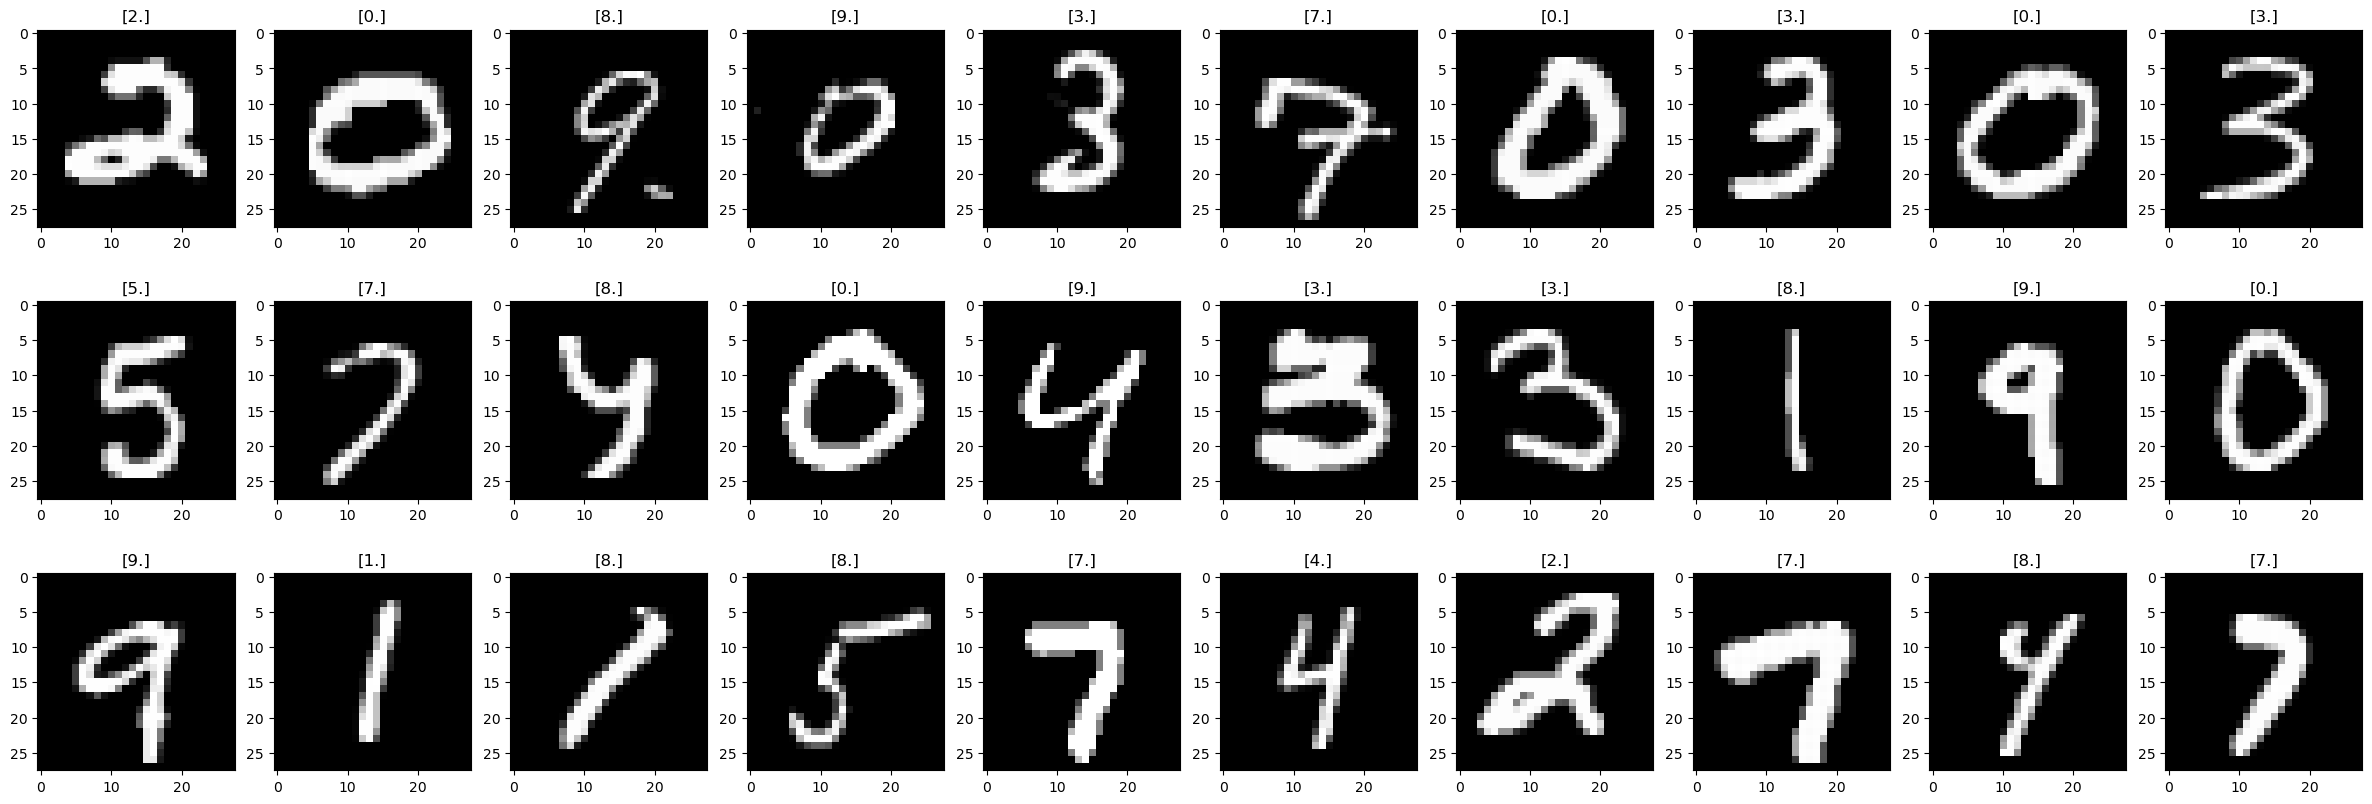

In [136]:
fig = plt.figure(figsize=(30, 10))
for i, img in enumerate(test_img[0:30], 1):
    subplot = fig.add_subplot(3, 10, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % pred_test[i - 1])

In [137]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write(f'{i},{int(p)}\n')

C:\Users\vpgusev\AppData\Local\Temp\ipykernel_12412\4179223048.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write(f'{i},{int(p)}\n')


# Conclusion
As a result of the work, classical machine learning models for recognizing handwritten digits were tested. On the test data, a score of 0.784 was obtained using the PCA method

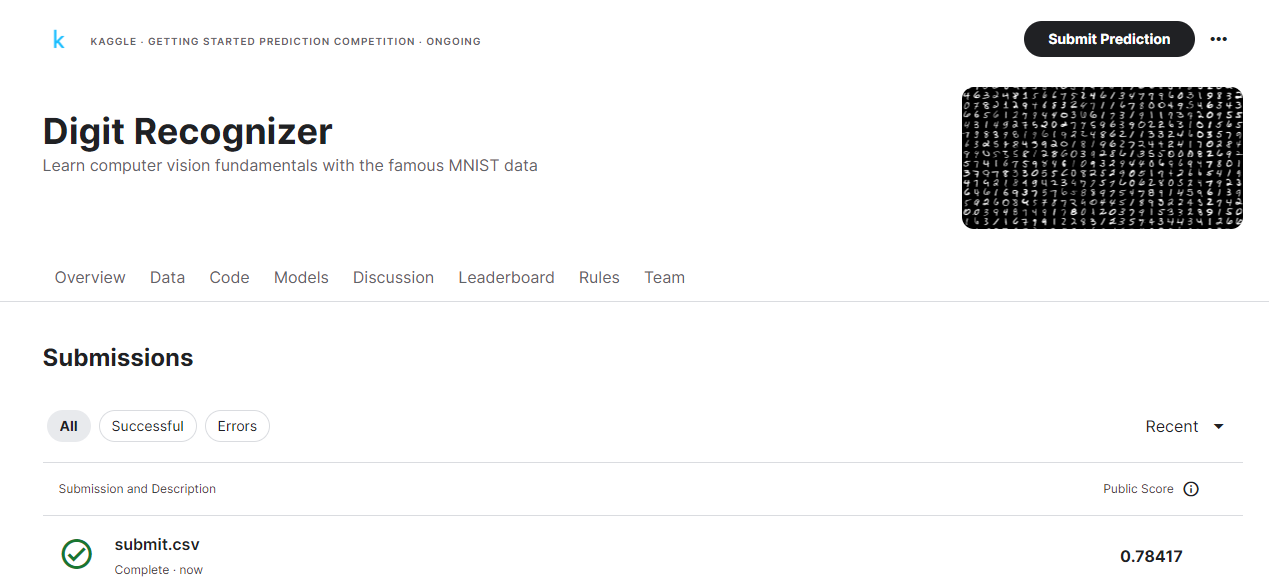